# Prevendo a evasão de clientes(Churn) e seu perfil

Definindo o problema de negócio:
Classifique se um cliente vai se desligar ou não. Quais as características desses clientes que deixaram a empresa? O que tem em comum? Como podemos evitar que determinados clientes se desliguem da empresa?

Estaremos resolvendo um problema de classificação com o objetivo de prever o resultado da variável 'Exited'.

**Os dados para esse projetos foram obtidos no Kaggle pelo seguinte** [link](https://www.kaggle.com/shubh0799/churn-modelling) 

# **Importação e Análise Exploratória dos dados**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Nesse conjunto de dados temos as seguintes variáveis:
- CustomerId: identificação do cliente;
- Surname: sobrenome do cliente;
- CreditScore: pontuação de credito, 0 alto risco de inadimplência e 1000 clientes com baixo risco de inadimplência;
- Geography: país que o serviço é oferecido;
- Gender: sexo do cliente;
- Age: idade do cleinte;
- Tenure: um indicativo de estabilidade no emprego, em que 0 significa pouca estabilidade e 10 muita estabilidade.
- Balance: saldo da conta corrente;
- NumOfProducts: número de produtos bancários adquiridos;
- HasCrCard: se tem cartão de credito ou não, (Sim = 1 e Não = 0);
- IsActiveMember: se é um cliente com conta ativa, (Ativo = 1) ;
- EstimatedSalary: salário estimado;
- Exited: cliente deixou de ser cliente do banco ou não (Churn = 1).

In [ ]:
df.shape

(10000, 14)

In [ ]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Deletando tabelas irrelevantes para a nossa análise(CustomerId, Surname e RowNumber):

In [ ]:
df = df.drop(columns=['CustomerId', 'Surname', 'RowNumber'])

In [ ]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Felizmente não foi necessário tratar dados ausentes.

In [ ]:
df.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

**Notamos que estamos trabalhando com clientes de três países: França, Alemanha, Espanha e 4 produtos distintos**

In [ ]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Observando a tabela que descreve os dados podemos dizer que os clientes dessa agência bancária possuem em *média*:**
* **39 anos**
* **Creditscore de 650 pontos**
* **Estabilidade de emprego de 5**
* **76 mil de saldo em sua conta e 1,5 produtos**
* **O salário estimado(EstimatedSalary) é de 100.000**
* **70% possuem cartão de crédito e 51% são membros ativos**

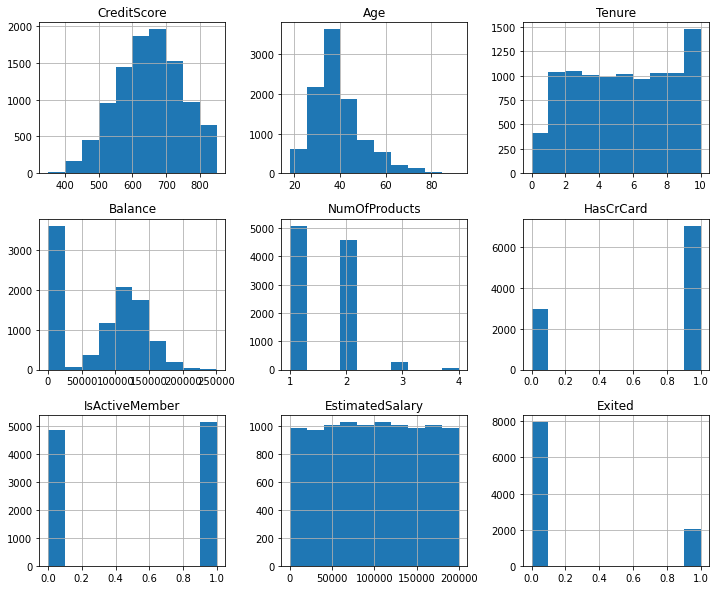

In [ ]:
df.hist(figsize=(12,10));

- **a maioria dos clientes têm entre 30 a 45 anos e poucos clientes têm idade superior a 60 anos.**
- **a variável balance mostra uma inflação de clientes que têm pouco dinheiro na conta bancária, isso pode implicar que talvez esses clientes possuem outra conta bancária.**
- **muitos clientes possuem 1 ou 2 produtos, mas poucos possuem 3 ou mais.**
- **cerca de 2mil clientes deixaram o banco, vamos analisar isso**

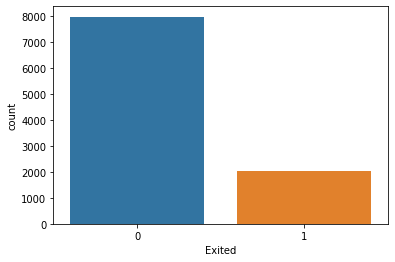

In [ ]:
sns.countplot(data=df,x='Exited');

Percebemos que cerca de 20%(2 mil) dos clientes forma classificados como 1 (cancelaram a conta ou mudaram de banco). Portanto, o modelo de base pode prever que 20% dos clientes se desligarão. Dado que 20% é um número pequeno, precisamos garantir que o modelo escolhido preveja com grande precisão esses 20%, pois é do interesse do banco identificar e manter esse grupo, em vez de prever com precisão os clientes que serão retidos.

**Iremos posteriormente, lidar com esse desbalanceamento entre as classes.**

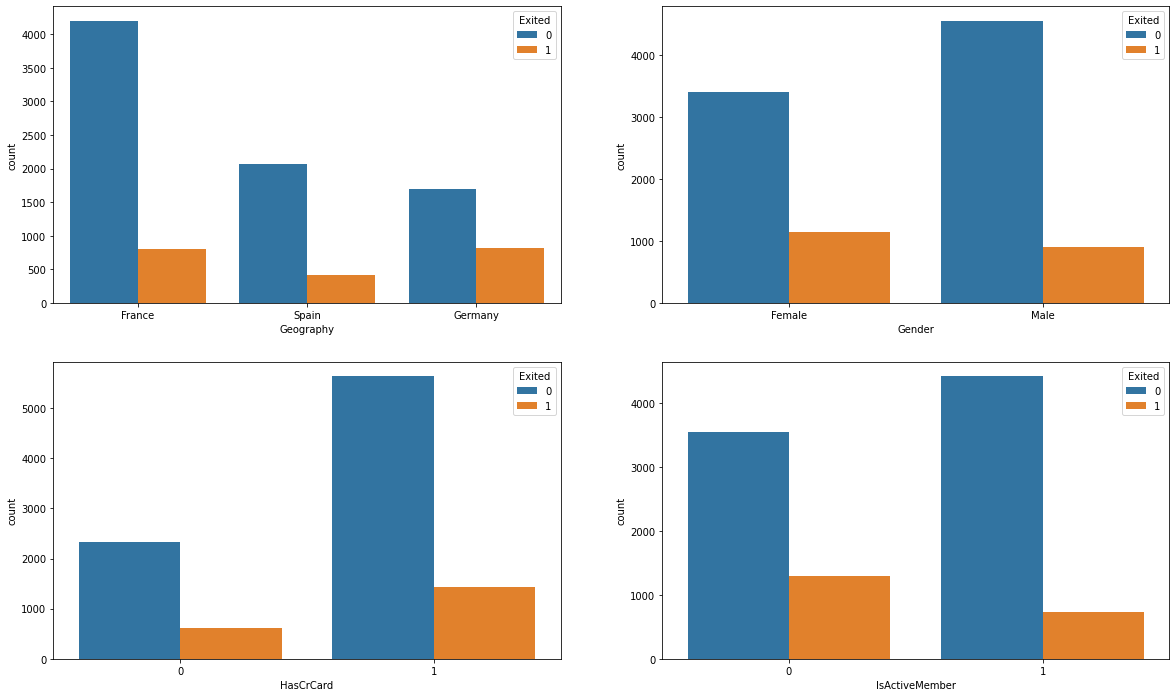

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

- **O numero de churn é maior entre as mulheres**
- **A maioria dos dados é de pessoas da França, mas uma proporção elevada de pessoas da alemanha deixaram o banco**
- **Curiosamente, a maioria dos clientes que mudaram são aqueles com cartões de crédito. Dado que a maioria dos clientes possui cartão de crédito poderá ser apenas uma coincidência.**
- **Não é surpresa que os membros inativos tenham uma rotatividade maior. O preocupante é que a proporção geral de clientes inativos é bastante alta, sugerindo que o banco pode precisar de um programa implementado para direcionar esse grupo para clientes ativos, pois isso definitivamente terá um impacto positivo na rotatividade de clientes.**

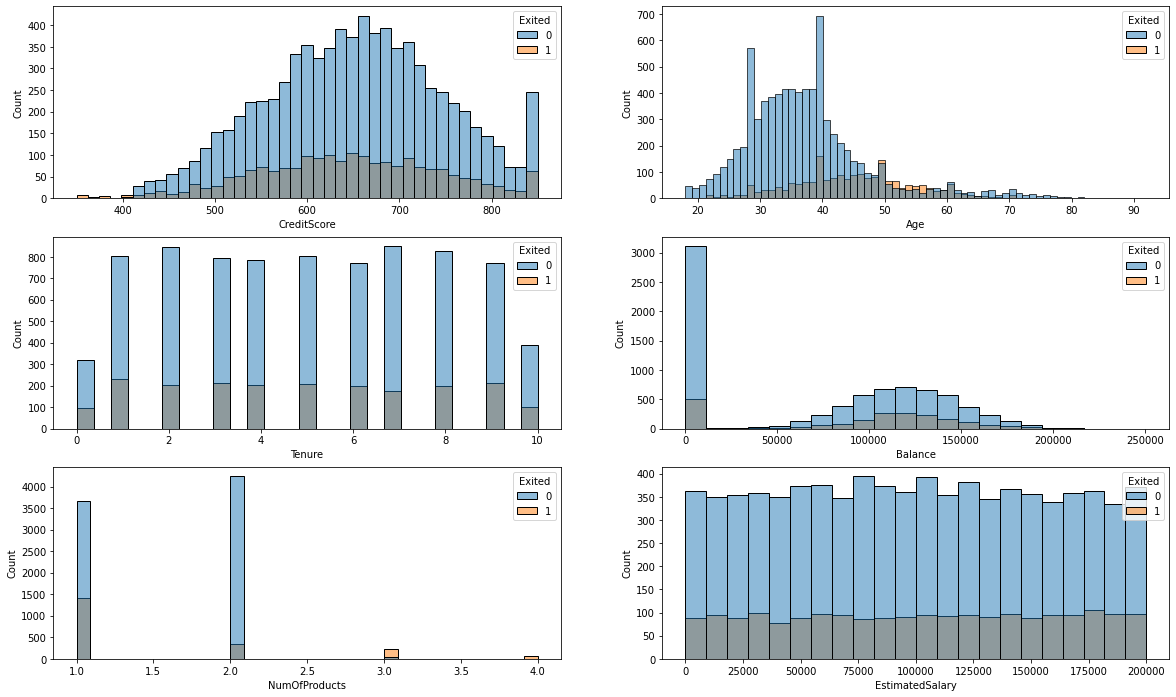

In [ ]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.histplot(x='CreditScore', hue = 'Exited', data = df, ax=axarr[0][0])
sns.histplot(x='Age', hue = 'Exited',data = df, ax=axarr[0][1])
sns.histplot(x='Tenure', hue = 'Exited',data = df, ax=axarr[1][0])
sns.histplot(x='Balance', hue = 'Exited',data = df, ax=axarr[1][1])
sns.histplot(x='NumOfProducts', hue = 'Exited',data = df, ax=axarr[2][0])
sns.histplot(x='EstimatedSalary', hue = 'Exited',data = df, ax=axarr[2][1])

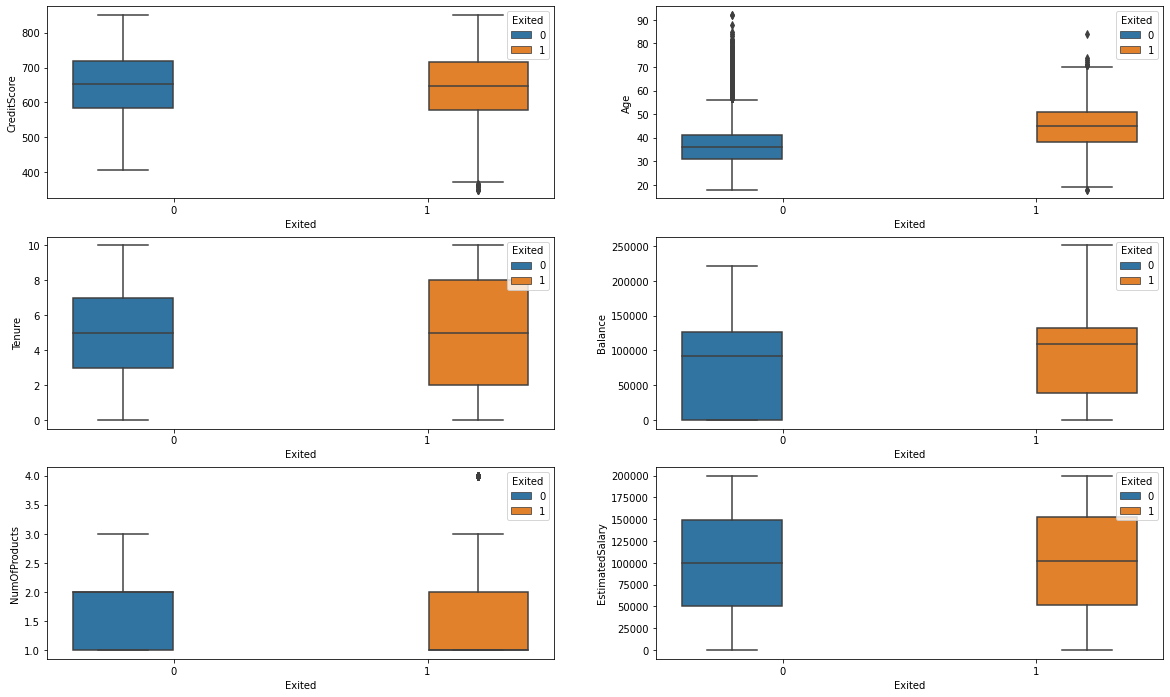

In [ ]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

- **Com relação à estabilidade, os clientes nas duas extremidades (gastaram pouco tempo com o banco ou muito tempo com o banco) são mais propensos a desistir em comparação com aqueles que têm mandato médio.**
- **Os clientes mais velhos estão saindo mais do que os mais jovens e observa-se a presença de outliers (pontos discrepantes).**
- **É preocupante que o banco esteja perdendo clientes com saldos bancários significativos. Há uma maior variância na variável Tenure para os clientes que deixaram o banco.**
- **Não há diferença significativa na distribuição dos produtos e salários entre as classes, implicando que no geral não influenciam tanto.**
- **Não há tanta diferença significativa na distribuição da pontuação de crédito entre clientes retidos e cancelados, exceto que no box-plot dos clientes que cancelaram o serviço, pode-se observar outliers na parte inferior e um limite inferior menor do que o boxplot dos clientes que não cancelaram o serviço. Indicando assim, que clientes que cancelaram o serviço possuem um score menor do que os clientes que não cancelaram o serviço.**

# **Pré-Processamento dos dados**

Devemos transformar a classe Gender(Genero) para um valor binário 1 e 0, pois algoritmos de Machine Learning não funcionam com strings, a função label encoder irá nos auxiliar com isso 

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender']) 
df.round()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.0,1,1,1,101349.0,1
1,608,Spain,0,41,1,83808.0,1,0,1,112543.0,0
2,502,France,0,42,8,159661.0,3,1,0,113932.0,1
3,699,France,0,39,1,0.0,2,0,0,93827.0,0
4,850,Spain,0,43,2,125511.0,1,1,1,79084.0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,1,39,5,0.0,2,1,0,96271.0,0
9996,516,France,1,35,10,57370.0,1,1,1,101700.0,0
9997,709,France,0,36,7,0.0,1,0,1,42086.0,1
9998,772,Germany,1,42,3,75075.0,2,1,0,92889.0,1


Temos um problema semelhante com as variáveis Geography e NumOfProducts. Para esse caso vamos utilizar a função get dummies do próprio pandas que transforma uma variável em variável dummy, ou seja, ele cria novas colunas de variáveis que também as transformam em binárias como feito com a variável Gender.

In [ ]:
df = pd.get_dummies (data = df, columns = ['Geography','NumOfProducts'] )
df.head()

,CreditScore,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,619,0,42,2,0.00,1,1,101348.88,1,1,0,0,1,0,0,0
1,608,0,41,1,83807.86,0,1,112542.58,0,0,0,1,1,0,0,0
2,502,0,42,8,159660.80,1,0,113931.57,1,1,0,0,0,0,1,0
3,699,0,39,1,0.00,0,0,93826.63,0,1,0,0,0,1,0,0
4,850,0,43,2,125510.82,1,1,79084.10,0,0,0,1,1,0,0,0


Observe que as variáveis numéricas Balance, Estimated Salary, Age e Credit Score estão em diferentes escalas e isso pode causar problemas na hora de treinarmos nossos modelos,  utilizaremos o StandardScaler que irá normalizar os dados de tal forma que a distribuição terá um valor médio 0 e um desvio padrão de 1. 

**Porém isso deve ser realizado após dividirmos nosso dataset em treino e teste, isso será feito logo a frente.**

#Preparando os dados de treino e teste e tratando as classes desbalanceadas



In [ ]:
y = df['Exited']
X = df.drop(['Exited'], axis=1)

In [ ]:
np.bincount(y)

array([7963, 2037])

Podemos notar que como constatado anteriormente, a variável target('Exited) está desbalaceada.

In [ ]:
#Separando a base em treino e teste
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Utilizando o método SMOTE para lidar com os dados desbalanceados

Definição da técnica Smote: Consiste em gerar dados sintéticos (não duplicados) da classe minoritária a partir de vizinhos.

In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()

In [ ]:
X_train, y_train = smt.fit_resample(X_train, y_train)

[5960 5960]


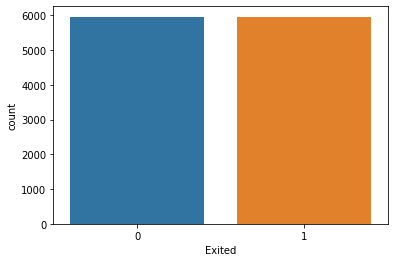

In [ ]:
print(np.bincount(y_train))
ax = sns.countplot(x=y_train)

Agora temos a mesma quantidade de dados para as duas classes, **vale lembrar que todo o projeto foi feito anteriormente sem o balanceamento das classes e que os resultados previstos pelos modelos foram insatisfatórios, por tal motivo o balanceamento tornou-se necessário, sendo constatado uma melhora significativa e Demonstrou a importância de trabalhar com dados balanceados!**

**Deixando as variáveis contínuas na mesma escala com o StandardScaler**

In [ ]:
#variáveis contínuas
c = ['CreditScore','Balance','Age','EstimatedSalary','Tenure']
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[c] = sc.fit_transform(X_train[c])
X_test[c] = sc.transform(X_test[c])

In [ ]:
X_train

,CreditScore,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,0.249924,1,1.810086,-1.765758,1.576320,0,1,-1.385839,1,0,0,0,1,0,0
1,2.198427,1,0.018198,1.176092,-0.343268,1,0,-1.199250,0,1,0,1,0,0,0
2,0.822366,0,-0.977296,0.440630,-1.340610,0,0,-0.687783,1,0,0,1,0,0,0
3,-0.069322,1,-0.778197,0.808361,1.519201,0,1,-0.989167,1,0,0,1,0,0,0
4,0.580179,1,-1.176394,1.543823,-1.340610,1,0,-0.872375,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11915,-0.718823,0,-0.479549,1.543823,0.857879,1,1,-0.521253,0,1,0,0,0,0,0
11916,-1.192188,1,-1.076845,-0.662564,0.879673,0,0,0.202104,0,0,0,1,0,0,0
11917,-0.113356,0,0.615494,-0.294833,-1.340610,1,0,-0.406431,1,0,0,0,0,0,0
11918,0.106814,0,-0.380000,-1.030295,-1.340610,0,0,-0.168077,0,0,0,1,0,0,0


In [ ]:
X_test

,CreditScore,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
6252,-0.597730,1,-0.877746,-0.662564,0.243669,0,0,-1.026525,0,1,0,0,1,0,0
4684,-0.300500,1,0.217297,-1.398027,-1.340610,1,1,0.786822,1,0,0,0,1,0,0
1731,-0.542687,0,0.316846,-0.294833,-1.340610,1,0,-0.735724,0,0,1,0,1,0,0
4742,-1.588494,1,1.810086,1.176092,0.611328,1,1,1.208132,0,1,0,0,1,0,0
4521,-0.994035,0,-1.375493,0.808361,0.707062,1,1,0.237058,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4862,-0.058314,0,1.411889,-1.398027,0.849268,0,1,-1.454638,0,0,1,1,0,0,0
7025,-0.894959,0,1.013691,-0.662564,-1.340610,1,0,-0.449244,0,0,1,0,0,1,0
7647,1.295731,1,-1.574592,-1.765758,-0.056333,1,1,-1.606849,1,0,0,1,0,0,0
7161,0.437069,0,-0.479549,0.440630,0.469271,0,0,-0.341624,1,0,0,1,0,0,0


Agora, nós podemos treinar modelos, ver como se saem e escolher o melhor a partir da medida de performace que é a ROC AUC que foi a escolhida por considerar a taxa de verdadeiros-positivos contra a taxa de falsos-positivos. Ou seja, numero de vezes que o classificador acertou a predição contra o número de vezes que o classificador errou a predição.

# Treinando os modelos
**Serão treinados e avaliados 4 modelos de classificação: Decision tree, Logistic Regression, Random Forest e XGB Classifier com seus parâmetros padrões para avaliar os melhores e posteriormente usar o grid/random search para a escolha dos melhores parâmetros e avaliar melhor sua performace pela acurácia, recall e a matriz de confusão.**

**DecisionTreeClassifier**

O classificador de árvore de decisão cria o modelo de classificação construindo uma árvore de decisão.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_dtc = dtc.predict(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score
rocTree = roc_auc_score(y_test, y_dtc)
print('roc_auc_score DecisionTreeClassifier = ', rocTree)

roc_auc_score DecisionTreeClassifier =  0.7070520979094739


**Cross Validation(CV)**

Vamos avaliar o desempenho do modelo com o Cross Validation(CV) que consiste em particionar os dados em conjuntos(partes), onde um conjunto é utilizado para treino e outro conjunto é utilizado para teste e avaliação do desempenho do modelo.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores_train = cross_val_score(dtc, X_train, y_train, cv=5)

In [ ]:
np.mean(scores_train)

0.8474832214765101

**LogisticRegression**

A regressão logística tem como objetivo produzir, a partir de um conjunto de observações, um modelo que permita a predição de valores tomados por uma variável categórica a partir de variáveis explicativas contínuas e/ou binárias.

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_lr = logistic.predict(X_test)

In [ ]:
rocRF = roc_auc_score(y_test, y_lr)
print('roc_auc_score LogisticRegression = ', rocRF)

roc_auc_score LogisticRegression =  0.7146473448780551


**RandomForestClassifier**

O modelo Random Forest é um modelo baseado em árvores de decisão, onde combinamos diversas árvores para obter a melhor predição.

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(random_state = 42)
rf.fit (X_train, y_train);

In [ ]:
y_rf = rf.predict(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score
rocRF = roc_auc_score(y_test, y_rf)
print('roc_auc_score RandomForestClassifier = ', rocRF)

roc_auc_score RandomForestClassifier =  0.7467425622130185


**XGBClassifier**

O modelo XGBoost (eXtreme Gradient Boosting), é uma categoria de modelos baseada nos algoritmos de árvores de decisão em combinação com os algoritmos de Gradient Boosting (gradiente aumentado). Além de ser um modelo robusto que não sofre tanta influência com dados desbalanceado.

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(random_state=42)

In [ ]:
y_xgb = xgb.predict(X_test)

In [ ]:
rocXGB = roc_auc_score(y_test, y_xgb)
print('roc_auc_score XGBClassifier = ', rocXGB)

roc_auc_score XGBClassifier =  0.7596166113003533


Diante dos resultados dos 4 modelos, os que se sairam melhor para prever o churn firam o RandomForest e o XGBbost mesmo sem o uso de parâmetros, vamos agora com o uso do GridSearch encontrar os melhores parametros para esses modelos e utiliza-los.

**Aplicando o GridSearch ao Random Forest**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = { 
'n_estimators': [200, 400, 600],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [6,7,8],
'criterion' :['gini', 'entropy']
}

In [ ]:
# grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv = 3)
# grid_rf.fit(X_train, y_train)

In [ ]:
#grid_rf.best_params_ 
#resultado: {'criterion': 'entropy', 'max_depth': 8,'max_features': 'auto','n_estimators': 600}

In [ ]:
rf2 = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=8, max_features='auto', n_estimators=600)

In [ ]:
rf2.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=600,
                       random_state=42)

In [ ]:
y_rf2 = rf2.predict(X_test)

In [ ]:
roc_rf = roc_auc_score(y_test, y_rf2)
print('roc_auc_score RandomForestClassifier = ', roc_rf)

roc_auc_score RandomForestClassifier =  0.7488827121490802


Tivemos um resultado inferior ao modelo sem os parâmetros, o que foi inesperado.

Devido a demora ao utilizar o GridSearch, no XGB vamos estar utilizando o RandomSearch.

**Aplicando RandomSearch ao XGB**

In [ ]:
params_xgb={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# xgb3 = XGBClassifier(random_state=42)
# random_xgb = RandomizedSearchCV(xgb3,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=10,verbose=3)
# random_xgb.fit(X_train,y_train)

In [ ]:
#print(random_xgb.best_estimator_)

In [ ]:
xgb3 = XGBClassifier(colsample_bytree=0.4, gamma=0.4, learning_rate=0.15, min_child_weight=3, random_state=42)
xgb3.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.4, gamma=0.4, learning_rate=0.15,
              min_child_weight=3, random_state=42)

In [ ]:
y_xgb3 = xgb3.predict(X_test)
rocXGB3 = roc_auc_score(y_test, y_xgb3)

In [ ]:
print('roc_auc_score XGB = ', rocXGB3)

roc_auc_score XGB =  0.7634288004612799


Os dois modelos que tiveram o melhor resultado foram o Random forest sem os parâmetros e o XGB após o uso do RandomForest com seus parâmetros encontrados.

Vamos avaliar ambos com outras métricas:

roc_auc_score RandomForest =  0.7467425622130185
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2003
           1       0.67      0.56      0.61       497

    accuracy                           0.86      2500
   macro avg       0.78      0.75      0.76      2500
weighted avg       0.85      0.86      0.85      2500



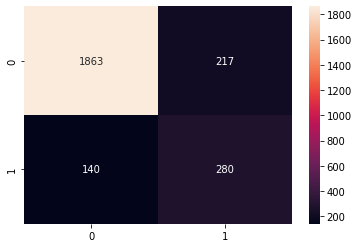

In [ ]:
#RandomForest
from sklearn.metrics import classification_report,confusion_matrix
cm_rf = confusion_matrix(y_rf, y_test)
sns.heatmap(cm_rf, annot=True, annot_kws={"size": 10},fmt="d");
rocRF = roc_auc_score(y_test, y_rf)
print('roc_auc_score RandomForest = ', rocRF)
print(classification_report(y_test, y_rf))

roc_auc_score XGB =  0.7634288004612799
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2003
           1       0.62      0.62      0.62       497

    accuracy                           0.85      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.85      0.85      0.85      2500



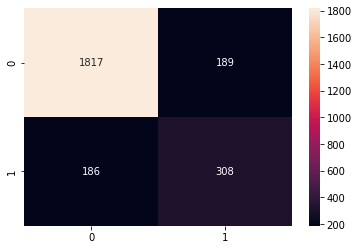

In [ ]:
#XGBClassifier
cm_xgb = confusion_matrix(y_xgb3, y_test)
sns.heatmap(cm_xgb, annot=True, annot_kws={"size": 10},fmt="d");
print('roc_auc_score XGB = ', rocXGB3)
print(classification_report(y_test, y_xgb3))

# Método Ensemble

Como o RadomForest e o XGB tiveram resultados quase idênticos uma estratégia a ser utilizada seria o uso do Método Essemble que combina os dois modelos para talvez alacançar melhores métricas de avaliação.

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2003
           1       0.66      0.59      0.62       497

    accuracy                           0.86      2500
   macro avg       0.78      0.76      0.77      2500
weighted avg       0.85      0.86      0.85      2500

Roc auc score VotingClassifier =  0.7565759007364204


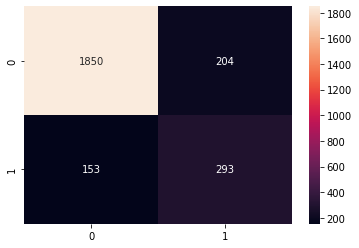

In [ ]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(estimators=[('rf', rf),('xgb3',xgb3)], voting='soft')
vc = vc.fit(X_train,y_train)
y_vc = vc.predict(X_test)
roc_VotingClassifier = roc_auc_score(y_test, y_vc)
print(classification_report(y_test, y_vc))
print('Roc auc score VotingClassifier = ', roc_VotingClassifier)
cm_vc = confusion_matrix(y_vc, y_test)
sns.heatmap(cm_vc, annot=True, annot_kws={"size": 10},fmt="d");

# O modelo utilizado será a Combinação do RandomForest com o XGB

Percebe-se que o modelo com uso do enssemble é o melhor, pois é o que fornece os melhores erros. Com este modelo, erramos em 167 clientes que saíram e não prevemos e 225 que ficaram e prevemos que saíram. Possívelmente podemos melhorar tunando melhor os hiperparâmetros ou talvez com o uso de redes neurais.

**Vamos estimar as variáveis mais importante para o Churn dos clientes:**

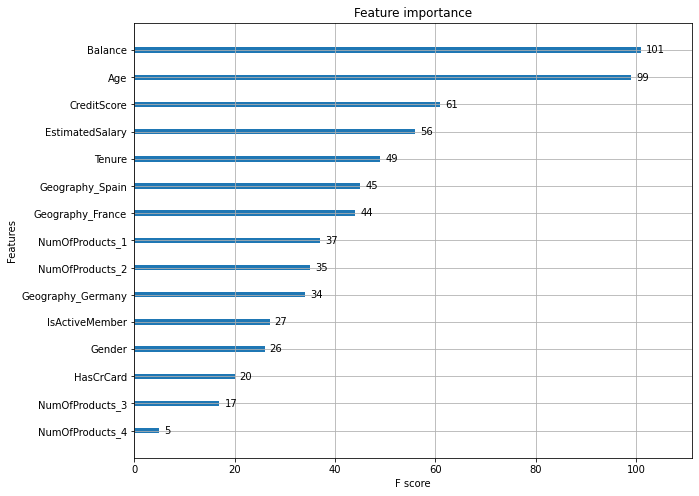

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb3, ax=ax)

**foram elas: idade, saldo bancário, pontuação de crédito, estimativa de salário, membro ativo e país Alemanha.**

# Concluindo

**A partir desse resultado, das características dos clientes que cancelaram o serviço e com a informação das varíaveis predominates para ocasionar o churn, o time de negócio poderá prever clientes com a maior de cancelamento e assim tomar medidas preventivas, afim de evitar essa saída.**

Salvando o modelo em um arquivo .pkl negrito

In [ ]:
import pickle
# Grava pickle
with open('modelo.pkl', 'wb') as f:
  pickle.dump(vc, f)

In [ ]:
# Lê pickle
with open('modelo.pkl', 'rb') as f:
  modelo = pickle.load(f)

In [ ]:
vc

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb3',
                              XGBClassifier(colsample_bytree=0.4, gamma=0.4,
                                            learning_rate=0.15,
                                            min_child_weight=3,
                                            random_state=42))],
                 voting='soft')